In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

In [3]:
# load csv (write the right path)
df = pd.read_csv("/content/NikeProductDescriptions.csv")


print(df.columns)


Index(['Title', 'Subtitle', 'Product Description'], dtype='object')


In [4]:
subtitles_to_keep = ["Men's Shoes", "Men's T-Shirt", "Women's Shoes","Skate Shoes", "Older Kids' T-Shirt", "Shorts"]

df.loc[df['Subtitle'].str.contains("Shorts", case=False, na=False), 'Subtitle'] = "Shorts"

df = df[df['Subtitle'].isin(subtitles_to_keep)].reset_index(drop=True)

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
def get_embedding(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**tokens)
    return outputs.last_hidden_state[0][0].numpy()

In [8]:
# embeddings
embeddings = []

for i in range(len(df)):
    desc = str(df.loc[i, 'Product Description'])
    emb = get_embedding(desc)
    embeddings.append(emb)

embeddings = np.array(embeddings)

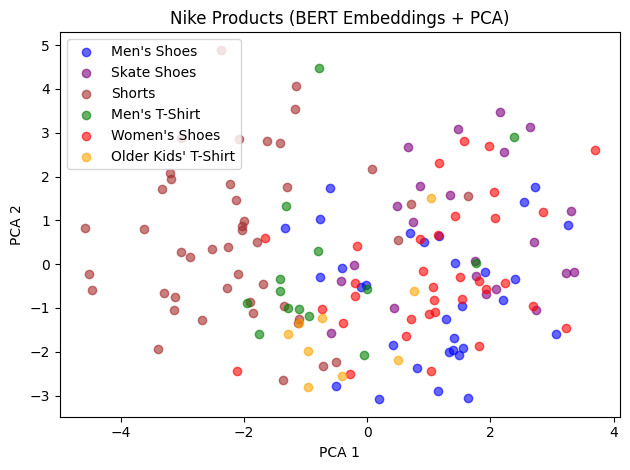

In [12]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
df['pca1'] = reduced[:, 0]
df['pca2'] = reduced[:, 1]

colors = {
    "Men's Shoes": 'blue',
    "Men's T-Shirt": 'green',
    "Women's Shoes": 'red',
    "Skate Shoes": 'purple',
    "Older Kids' T-Shirt": 'orange',
    "Shorts": 'brown'
}

for subtitle in df['Subtitle'].unique():
    temp = df[df['Subtitle'] == subtitle]
    plt.scatter(temp['pca1'], temp['pca2'], label=subtitle, c=colors[subtitle], alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Products (BERT Embeddings + PCA)")
plt.legend()
plt.tight_layout()
plt.show()